In [ ]:
import os
os.chdir('../')

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import random

from torch.utils.data import DataLoader, Subset

import albumentations as A
from albumentations.pytorch import ToTensorV2

from datasets.cityscapes import Cityscapes
from datasets.bdd100k import BDD100KSeg
from datasets.road_anomaly import RoadAnomaly
from datasets.fishyscapes import FishyscapesLAF, FishyscapesStatic
from datasets.segment_me_if_you_can import RoadAnomaly21, RoadObstacle21
from datasets.lost_and_found import LostAndFound
from easydict import EasyDict as edict
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex

from tqdm.notebook import tqdm

from config.config import config
from model.network import Network

from analysis.ood import OODAnalyzer, OODEvaluator

In [ ]:
# !pip install --upgrade git+https://github.com/NazirNayal8/analyze.git

# Paths


In [ ]:
ckpt_path = '../ckpts/pretrained_ckpts/best_ad_ckpt.pth'

# Dataset Configs

In [ ]:
bdd100k_config = edict({
    'seg_downsample_rate': 1,
    'train_file': 'train_paths.txt',
    'val_file': 'val_paths.txt',
    'val_image_strategy': 'no_change',
    'ignore_train_class': True,
    'dataset_root': '/home/user/datasets/bdd100k/seg'
})

cityscapes_config = edict({
    'dataset_root': '/home/user/datasets/cityscapes',
})

road_anomaly_config = edict({
    'dataset_root': '/home/user/datasets/RoadAnomaly/RoadAnomaly_jpg',
    'test_image_strategy': 'no_change'
})

fishyscapes_laf_config = edict({
    'dataset_root': '/home/user/datasets/Fishyscapes/',
})

fishyscapes_static_config = edict({
    'dataset_root': '/home/user/datasets/Fishyscapes/',
})

road_anomaly_21_config = edict({
    'dataset_root': '/home/user/datasets/SegmentMeIfYouCan/dataset_AnomalyTrack',
    'dataset_mode': 'all'
})

road_obstacle_21_config = edict({
    'dataset_root': '/home/user/datasets/SegmentMeIfYouCan/dataset_ObstacleTrack',
    'dataset_mode': 'all'
})

laf_config = edict(
    dataset_root='/home/user/datasets/LostAndFound',
)



# Create Datasets

In [ ]:
# Cityscapes
transform = A.Compose([
    A.Normalize(mean=config.image_mean, std=config.image_std),
    ToTensorV2()
])
cityscapes_dataset = Cityscapes(cityscapes_config, transform=transform, split='val', 
                                target_type='semantic')
loader_cityscapes = DataLoader(cityscapes_dataset, batch_size=1, shuffle=False, num_workers=15)

# BDD100K
transform_bdd100k = A.Compose([
    A.Normalize(mean=config.image_mean, std=config.image_std),
    ToTensorV2(),
])
bdd100k_dataset = BDD100KSeg(hparams=bdd100k_config, mode='val', transforms=transform_bdd100k, 
                             image_size=(720, 1280))
loader_bdd100k = DataLoader(bdd100k_dataset, batch_size=1, shuffle=False, num_workers=15)
# Road Anomaly
transform_road_anomaly = A.Compose([
    A.Normalize(mean=config.image_mean, std=config.image_std),
    ToTensorV2()
])
road_anomaly_dataset = RoadAnomaly(hparams=road_anomaly_config, transforms=transform_road_anomaly)
loader_road_anomaly = DataLoader(road_anomaly_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes LaF
transform_fs_laf = A.Compose([
    A.Normalize(mean=config.image_mean, std=config.image_std),
    ToTensorV2()
])
fs_laf_dataset = FishyscapesLAF(hparams=fishyscapes_laf_config, transforms=transform_fs_laf)
loader_fs_laf = DataLoader(fs_laf_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes Static
transform_fs_static = A.Compose([
    A.Normalize(mean=config.image_mean, std=config.image_std),
    ToTensorV2()
])
fs_static_dataset = FishyscapesStatic(hparams=fishyscapes_static_config, transforms=transform_fs_static)
loader_fs_static = DataLoader(fs_static_dataset, batch_size=1, shuffle=False, num_workers=15)

# Road Anomaly 21
transform_ra_21 = A.Compose([
    A.Resize(height=720, width=1280),
    A.Normalize(mean=config.image_mean, std=config.image_std),
    ToTensorV2()
])
road_anomaly_21_dataset = RoadAnomaly21(hparams=road_anomaly_21_config, transforms=transform_ra_21)
loader_road_anomaly_21 = DataLoader(road_anomaly_21_dataset, batch_size=1, shuffle=False, num_workers=15)

# Lost And Found
transforms_laf = A.Compose([
    A.Normalize(mean=config.image_mean, std=config.image_std),
    ToTensorV2()
])

laf_dataset = LostAndFound(laf_config, transforms_laf) 
loader_laf = DataLoader(laf_dataset, batch_size=1, shuffle=False, num_workers=15)

# Load the Model

In [ ]:
def load_ckpt(path):
    state_dict = torch.load(path)
    if 'model' in state_dict.keys():
        state_dict = state_dict['model']
    model = Network(config.num_classes, wide=True)
    
    model.load_state_dict(state_dict, strict=True)
    model.eval()
    model.cuda()
    return model

In [ ]:
model = load_ckpt(ckpt_path)

In [ ]:
model

# Util Functions

In [ ]:
def get_logits(model, x, **kwargs):
    
    with torch.no_grad():
        out = model(x)
    
    return out

def get_anomaly_score(model, x, **kwargs):
    
    with torch.no_grad():
        out = model(x, output_anomaly=True)
    
    return out

# Close-Set Evaluations

In [ ]:
analyzer = OODAnalyzer(
    model=model, 
    inference_func=get_logits,
    anomaly_score_func=get_anomaly_score,
    anomaly_id=1
)

## Cityscapes mIoU

In [ ]:
mIoU_cityscapes = analyzer.evaluate_mIoU(
    dataset=cityscapes_dataset,
    num_classes=20, 
    ignore_index=19, 
    batch_size=1,
    device=torch.device('cuda'),
    num_workers=15
 )

In [ ]:
mIoU_cityscapes

## BDD100K mIoU

In [ ]:
mIoU_bdd100k = analyzer.evaluate_mIoU(
    dataset=bdd100k_dataset,
    num_classes=20, 
    ignore_index=19, 
    batch_size=1,
    device=torch.device('cuda'),
    num_workers=15
 )

In [ ]:
mIoU_bdd100k

# OOD Evaluation

In [ ]:
ood_evaluator = OODEvaluator(
    model, 
    get_logits,
    get_anomaly_score,
)

## Road Anomaly

In [ ]:
anomaly_score_ra, ood_gts_ra, preds_ra = ood_evaluator.compute_anomaly_scores(
    loader=loader_road_anomaly,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_ra = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_ra,
    ood_gts=ood_gts_ra,
    verbose=True
)

In [ ]:
imgs_ra = ood_evaluator.get_imgs(
    road_anomaly_dataset, 
    image_mean=config.image_mean, 
    image_std=config.image_std,
    out_type=np.float32
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='road_anomaly_test',
    run_name='pebal_wideresnet34',
    imgs=imgs_ra,
    ood_gts=ood_gts_ra,
    preds=preds_ra,
    anomaly_score= anomaly_score_ra,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_ra
)

### Fishyscapes LaF

In [ ]:
anomaly_score_fs_laf, ood_gts_fs_laf, preds_fs_laf = ood_evaluator.compute_anomaly_scores(
    loader=loader_fs_laf,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_fs_laf = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf,
    ood_gts=ood_gts_fs_laf,
    verbose=True
)

In [ ]:
imgs_fs_laf = ood_evaluator.get_imgs(
    fs_laf_dataset, 
    image_mean=config.image_mean, 
    image_std=config.image_std,
    out_type=np.float32
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='fishyscapes_laf',
    run_name='pebal_wideresnet34',
    imgs=imgs_fs_laf,
    ood_gts=ood_gts_fs_laf,
    preds=preds_fs_laf,
    anomaly_score= anomaly_score_fs_laf,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_laf
)

### Fishyscapes Static

In [ ]:
anomaly_score_fs_static, ood_gts_fs_static, preds_fs_static = ood_evaluator.compute_anomaly_scores(
    loader=loader_fs_static,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_fs_static = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_fs_static,
    ood_gts=ood_gts_fs_static,
    verbose=True
)

In [ ]:
imgs_fs_static = ood_evaluator.get_imgs(
    fs_static_dataset, 
    image_mean=config.image_mean, 
    image_std=config.image_std,
    out_type=np.float32
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='fishyscapes_static',
    run_name='pebal_wideresnet34',
    imgs=imgs_fs_static,
    ood_gts=ood_gts_fs_static,
    preds=preds_fs_static,
    anomaly_score= anomaly_score_fs_static,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_static
)

### Lost And Found

In [ ]:
anomaly_score_laf, ood_gts_laf, preds_laf = ood_evaluator.compute_max_logit_scores(
    #loader=DataLoader(Subset(laf_dataset, np.random.choice(np.arange(len(laf_dataset)), 800, replace=False)), batch_size=1, shuffle=False, num_workers=15),
    loader=loader_laf,
    device=torch.device('cuda'),
    return_preds=True,
    upper_limit=1250
)

metrics_laf = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_laf,
    ood_gts=ood_gts_laf,
    verbose=True
)

In [ ]:
ood_mask = (ood_gts_laf == 1)
ind_mask = (ood_gts_laf == 0)

ood_out = anomaly_score_laf[ood_mask]
ind_out = anomaly_score_laf[ind_mask]

ood_out = np.unique(np.round(ood_out, 10))
ind_out = np.unique(np.round(ind_out, 10))

ood_label = np.ones(len(ood_out))
ind_label = np.zeros(len(ind_out))

val_out = np.concatenate((ind_out, ood_out))
val_label = np.concatenate((ind_label, ood_label))

In [ ]:
len(val_out)

In [ ]:
auroc, aupr, fpr = ood_evaluator.calculate_ood_metrics(val_out, val_label)

print(f'Max Logits: AUROC score: {auroc}')
print(f'Max Logits: AUPRC score: {aupr}')
print(f'Max Logits: FPR@TPR95: {fpr}')

In [ ]:
# Max Logits: AUROC score: 0.7635324685648839
# Max Logits: AUPRC score: 0.6216699920945048
# Max Logits: FPR@TPR95: 0.8821651142995772

In [ ]:
v_u = np.unique(val_out)

In [ ]:
len(v_u)

In [ ]:
idx = -230

im, lb = laf_dataset[idx]

plt.imshow(anomaly_score_laf[idx].squeeze())
plt.show()
plt.imshow(im.permute(1, 2, 0))
plt.show()
plt.imshow(laf_dataset[idx][1])
plt.show()
m = lb.clone()
k = 1
m[lb == k] = 1
m[lb != k] = 0
plt.imshow(m)
plt.show()

In [ ]:
imgs_laf = ood_evaluator.get_imgs(
    laf_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='lost_and_found',
    run_name='mask2former_swin_b_dec_layers_2_res5_only_max_logits',
    imgs=imgs_laf,
    ood_gts=ood_gts_laf,
    preds=preds_laf,
    anomaly_score= anomaly_score_laf,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_laf
)

### Road Anomaly 21 (Qualitative)

In [ ]:
anomaly_score_ra_21, ood_gts_ra_21, preds_ra_21 = ood_evaluator.compute_max_logit_scores(
    loader=loader_road_anomaly_21,
    device=torch.device('cuda'),
    return_preds=True,
)

In [ ]:
imgs_ra_21 = ood_evaluator.get_imgs(
    road_anomaly_21_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='road_anomaly_21',
    run_name='mask2former_swin_b_dec_layers_2_res5_only_max_logits',
    imgs=imgs_ra_21,
    ood_gts=ood_gts_ra_21,
    preds=preds_ra_21,
    anomaly_score= anomaly_score_ra_21,
    class_names=bdd100k_dataset.class_names,
    metrics=None
)

### BDD100K (Qualitative)

In [ ]:
anomaly_score_bdd100k, ood_gts_bdd100k, preds_bdd100k = ood_evaluator.compute_max_logit_scores(
    loader=loader_bdd100k,
    device=torch.device('cuda'),
    return_preds=True,
    upper_limit=450
)

In [ ]:
imgs_bdd100k = ood_evaluator.get_imgs(
    bdd100k_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='bdd100k_anomaly_eval',
    run_name='mask2former_swin_b_replication_max_logits',
    imgs=imgs_bdd100k,
    ood_gts=ood_gts_bdd100k,
    preds=preds_bdd100k,
    anomaly_score= anomaly_score_bdd100k,
    class_names=bdd100k_dataset.class_names,
    metrics=None,
    upper_limit=450
)

# Bootstrapped Evaluation

In [133]:
from sklearn.metrics import roc_curve, auc, average_precision_score

In [ ]:
ratio=0.9
trials=20

In [ ]:
metrics_fs_laf = ood_evaluator.evaluate_ood_bootstrapped(
    dataset=fs_laf_dataset,
    ratio=ratio,
    trials=trials,
    device=torch.device('cuda'),
)

In [ ]:
metrics_fs_laf

In [ ]:
metrics_fs_static = ood_evaluator.evaluate_ood_bootstrapped(
    dataset=fs_static_dataset,
    ratio=ratio,
    trials=trials,
    device=torch.device('cuda'),
)

In [ ]:
metrics_fs_static

In [ ]:
metrics_ra = ood_evaluator.evaluate_ood_bootstrapped(
    dataset=road_anomaly_dataset,
    ratio=ratio,
    trials=trials,
    device=torch.device('cuda'),
)

In [ ]:
metrics_ra

# Understanding Effect on Metrics

In [76]:
from kornia.morphology import gradient

In [32]:
anomaly_score_fs_laf, ood_gts_fs_laf = ood_evaluator.compute_anomaly_scores(
    loader=loader_fs_laf,
    device=torch.device('cuda'),
    return_preds=False,
)

metrics_fs_laf = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf,
    ood_gts=ood_gts_fs_laf,
    verbose=True
)

Dataset Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


Calculating Metrics for 170619888 Points ...
Max Logits: AUROC score: 0.9896339953892744
Max Logits: AUPRC score: 0.5881274359871297
Max Logits: FPR@TPR95: 0.04766250498759202


In [33]:
anomaly_score_fs_laf = anomaly_score_fs_laf.squeeze()
ood_gts_fs_laf = ood_gts_fs_laf.squeeze()

ood_gts_color = ood_gts_fs_laf.copy()
ood_gts_color[ood_gts_fs_laf == 1] = 128

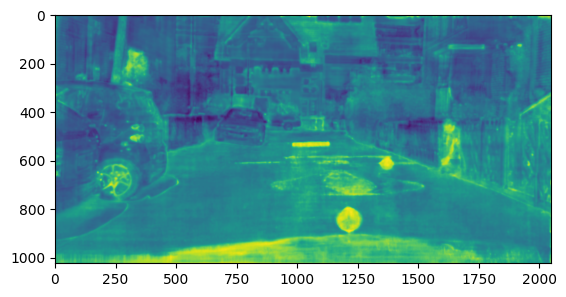

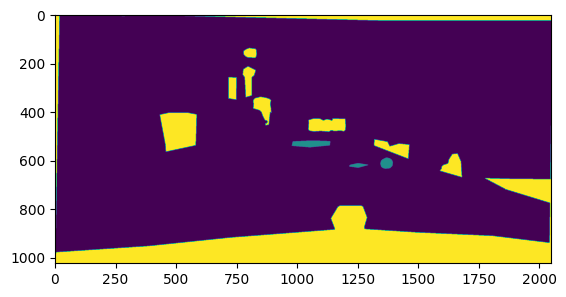

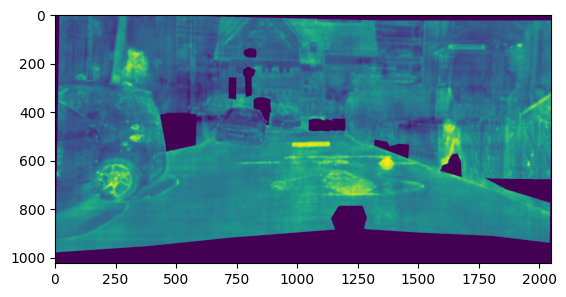

Calculating Metrics for 1760014 Points ...
Max Logits: AUROC score: 0.9709513466927503
Max Logits: AUPRC score: 0.6324972550832061
Max Logits: FPR@TPR95: 0.13791204217377867


In [229]:
idx = 65
plt.imshow(anomaly_score_fs_laf[idx])
plt.show()
plt.imshow(ood_gts_color[idx])
plt.show()

filtered_score = anomaly_score_fs_laf[idx].copy()
filtered_score[ood_gts_fs_laf[idx] == 255] = anomaly_score_fs_laf[idx].min()
plt.imshow(filtered_score)
plt.show()

metrics_fs_laf = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf[idx],
    ood_gts=ood_gts_fs_laf[idx],
    verbose=True
)

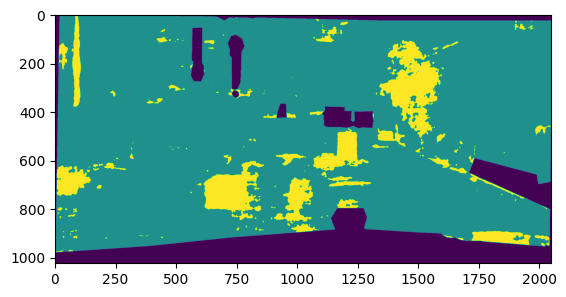

In [226]:
id_region = anomaly_score_fs_laf[idx].copy()
thr = -9.89
id_region[(anomaly_score_fs_laf[idx] > thr) & (ood_gts_fs_laf[idx] != 255)] = 256
id_region[anomaly_score_fs_laf[idx] < thr] = 128
id_region[ood_gts_fs_laf[idx] == 255] = 0

plt.imshow(id_region)
plt.show()

In [225]:
ood_mask = (ood_gts_fs_laf[idx] == 1)
ind_mask = (ood_gts_fs_laf[idx] == 0)

ood_out = anomaly_score_fs_laf[idx][ood_mask]
ind_out = anomaly_score_fs_laf[idx][ind_mask]

ood_label = np.ones(len(ood_out))
ind_label = np.zeros(len(ind_out))

val_out = np.concatenate((ind_out, ood_out))
val_label = np.concatenate((ind_label, ood_label))

fpr, tpr, thresholds = roc_curve(val_label, val_out)
fpr95_threshold = np.where(tpr > 0.95)[0].min()

print(thresholds[fpr95_threshold])

-9.893292


In [173]:
thresholds[k.min()]

-6.2834783

In [25]:
val_min = anomaly_score_fs_laf.min() 
val_max = anomaly_score_fs_laf.max()
val_mean = anomaly_score_fs_laf.mean()
val_std = anomaly_score_fs_laf.std()

val_min, val_max, val_mean, val_std

(-19.06358, -2.9048254, -10.95426, 2.1439402)

In [27]:
ood_min = anomaly_score_fs_laf[ood_gts_fs_laf == 1].min() 
ood_max = anomaly_score_fs_laf[ood_gts_fs_laf == 1].max()
ood_mean = anomaly_score_fs_laf[ood_gts_fs_laf == 1].mean()
ood_std = anomaly_score_fs_laf[ood_gts_fs_laf == 1].std()

print("OOD Min", ood_min)
print("OOD Max", ood_max)
print("OOD Mean", ood_mean)
print("OOD STD", ood_std)
print("----------------------")

id_min = anomaly_score_fs_laf[ood_gts_fs_laf == 0].min() 
id_max = anomaly_score_fs_laf[ood_gts_fs_laf == 0].max()
id_mean = anomaly_score_fs_laf[ood_gts_fs_laf == 0].mean()
id_std = anomaly_score_fs_laf[ood_gts_fs_laf == 0].std()

print("ID Min", id_min)
print("ID Max", id_max)
print("ID Mean", id_mean)
print("ID STD", id_std)
print("----------------------")

void_min = anomaly_score_fs_laf[ood_gts_fs_laf == 255].min() 
void_max = anomaly_score_fs_laf[ood_gts_fs_laf == 255].max()
void_mean = anomaly_score_fs_laf[ood_gts_fs_laf == 255].mean()
void_std = anomaly_score_fs_laf[ood_gts_fs_laf == 255].std()

print("Void Min", void_min)
print("Void Max", void_max)
print("Void Mean", void_mean)
print("Void STD", void_std)

OOD Min -12.622355
OOD Max -2.9048254
OOD Mean -5.4959707
OOD STD 1.7291251
----------------------
ID Min -19.06358
ID Max -3.0860577
ID Mean -11.53986
ID STD 1.48272
----------------------
Void Min -18.66045
Void Max -2.9239807
Void Mean -8.472471
Void STD 2.6526902
